In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
np.random.seed(0)

1. Initialize map
- Define 2D grid of nodes, each ass. with a weight vector of the same dim as the input data
- Init these weight vectors randomly or by sampling from the input space

2. Set training parameters
- Learning rate, Neighborhood radius (sigma), Epochs

3. For each training iteration, repeat the following:
- a. Select input vector X randomly
- b. Find the winning node (best matching unit- BMU):
Compute the distance (euclidean) between X and the weight vectors of all nodes, and select the node with the smallest distance
- c. Update weights:
Adjust the weights of the BMU and its neighbors to move closer to X. 
W(t+1) = W(t) + eta(t)*h_BMU(t)*(X-W(t))

where eta is learning rate at iteration t, h_BMU is the neighborhood function (Gaussian), gradually reduce eta and sigma over iterations. 
- d. repeat

In [2]:
class SOM:
    def __init__(self, input_dim, output_dim, learning_rate=0.2, sigma=50, task='animal'):
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.task = task
        if task == 'votes':
            self.weights = np.random.rand(output_dim, output_dim, input_dim)
        else:
            self.weights = np.random.rand(output_dim, input_dim)

    def train(self, data, epochs):
        initial_learning_rate = self.learning_rate
        initial_sigma = self.sigma
        
        for epoch in range(epochs):
            for x in data:
                bmu = self.find_best_matching_unit(x)
                # Cast neighborhood_radius to int
                self.update_weights(x, bmu)
            # Update learning rate, sigma, and neighborhood radius
            self.learning_rate = initial_learning_rate * np.exp(-epoch / epochs)
            if self.task == 'votes':
                self.sigma = max(0, initial_sigma * np.exp(-epoch / epochs))

            else:
                
                self.sigma = max(0, self.sigma - 1)

    def find_best_matching_unit(self, x):
        if self.task == 'votes':
            # We need to retun the index as (row, column)
            dist = np.linalg.norm(self.weights - x, axis=2)
            return np.unravel_index(np.argmin(dist), dist.shape) 
        else:
            # We need to return the index as a single number
            dist = np.linalg.norm(self.weights - x, axis=1)
            return np.argmin(dist) # Return index of the best matching unit
    
    def update_weights(self, x, bmu_idx):
        if self.task == 'animal':
            for i in range(self.output_dim):
                distance = np.linalg.norm(i - bmu_idx)
                if distance <= self.sigma:
                    influence = np.exp(-distance**2 / (2 * self.sigma**2))
                    self.weights[i] += self.learning_rate * influence * (x - self.weights[i])
        elif self.task == 'cities':
            # Neighborhood is a circle, and the first and last cities are neighbors
            for i in range(self.output_dim):
                distance = min(abs(i - bmu_idx), self.output_dim - abs(i - bmu_idx))
                if distance <= self.sigma:
                    influence = np.exp(-distance**2 / (2 * self.sigma**2))
                    self.weights[i] += self.learning_rate * influence * (x - self.weights[i])
        elif self.task == 'votes':
            for row in range(self.output_dim):
                for col in range(self.output_dim):
                    distance = np.linalg.norm(np.array([row, col]) - np.array(bmu_idx))
                    if distance <= self.sigma:
                        influence = np.exp(-distance**2 / (2 * self.sigma**2))
                        self.weights[row, col] += self.learning_rate * influence * (x - self.weights[row, col])
                        

                    
    def map_data_to_bmu(self, data):
        return np.array([self.find_best_matching_unit(x) for x in data])

In [3]:
def read_animals():
    animal_names = pd.read_csv('data_lab2/animalnames.txt', header=None)
    animal_names = animal_names.rename(columns={0: 'name'})
    animal_names['name'] = animal_names['name'].str.replace("'", "").str.strip()
    animal_names = animal_names['name'].values

    animal_dat = pd.read_csv('data_lab2/animals.dat', header=None)
    animal_dat = animal_dat.values.reshape(32, 84)

    return animal_names, animal_dat


In [4]:
# Load data
animal_names, animal_dat = read_animals()

# Initialize and train the SOM
som = SOM(input_dim=84, output_dim=100, learning_rate=0.2, sigma=50, task='animal')

som.train(animal_dat, epochs=20)

# Map animals to BMUs
bmus = som.map_data_to_bmu(animal_dat)

# Sort and display animals by BMU and their respective BMU
sorted_indices = np.argsort(bmus)
sorted_animals = [animal_names[i] for i in sorted_indices]
print("Sorted Animals by BMU:", sorted_animals, "\n", bmus[sorted_indices])



Sorted Animals by BMU: ['beetle', 'butterfly', 'moskito', 'housefly', 'dragonfly', 'grasshopper', 'spider', 'frog', 'seaturtle', 'pelican', 'crocodile', 'penguin', 'ostrich', 'duck', 'walrus', 'ape', 'rabbit', 'bear', 'hyena', 'cat', 'rat', 'skunk', 'dog', 'lion', 'elephant', 'bat', 'pig', 'giraffe', 'camel', 'kangaroo', 'horse', 'antelop'] 
 [ 0  0  0  0  0  5 10 36 42 42 42 43 43 46 67 74 77 78 78 78 78 79 79 81
 98 98 99 99 99 99 99 99]


In [5]:
def read_cities():
    cities = pd.read_csv('data_lab2/cities.dat', header=None)
    cities = cities.rename(columns={0: 'x', 1: 'y'})
    cities['y'] = cities['y'].str.replace(";", "").str.strip()
    cities['y'] = cities['y'].astype(float)
    cities['x'] = cities['x'].astype(float)
    cities = cities.values
    return cities

In [6]:
cities = read_cities()
print(cities)

[[0.4    0.4439]
 [0.2439 0.1463]
 [0.1707 0.2293]
 [0.2293 0.761 ]
 [0.5171 0.9414]
 [0.8732 0.6536]
 [0.6878 0.5219]
 [0.8488 0.3609]
 [0.6683 0.2536]
 [0.6195 0.2634]]


In [7]:
cities_som = SOM(input_dim=2, output_dim=10, learning_rate=0.2, sigma=2, task='cities')

cities_som.train(cities, epochs=20)

# Map cities to BMUs
bmus = cities_som.map_data_to_bmu(cities)

# Sort and display cities by BMU
sorted_indices = sorted(range(len(bmus)), key=lambda i: bmus[i])
sorted_cities = cities[sorted_indices]

/tmp/ipykernel_934838/3965627373.py:53: RuntimeWarning: invalid value encountered in scalar divide
  influence = np.exp(-distance**2 / (2 * self.sigma**2))


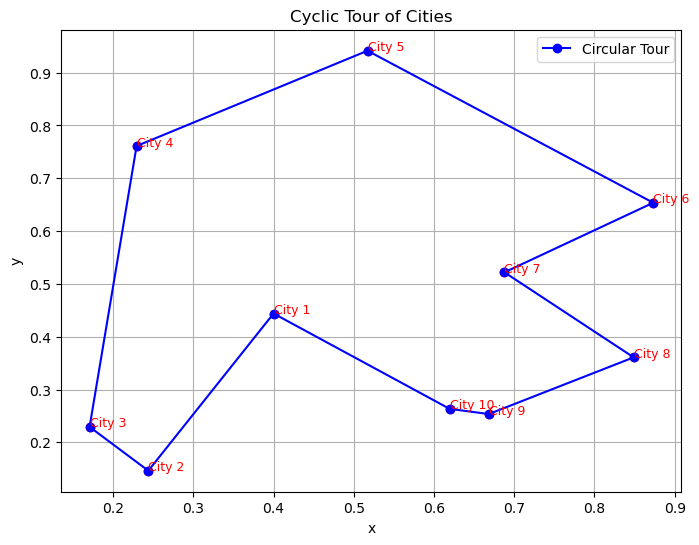

In [8]:
# Plot the sorted cities with numbers and complete the circle
plt.figure(figsize=(8, 6))
plt.plot(sorted_cities[:, 0], sorted_cities[:, 1], 'o-', label='Circular Tour', color='blue')
plt.scatter(sorted_cities[:, 0], sorted_cities[:, 1], color='red')

# Add annotations for city numbers
for idx, (x, y) in enumerate(sorted_cities):
    plt.text(x, y, f'City {str(sorted_indices[idx] + 1)}', fontsize=9, color='red')

# Complete the circle by connecting the last city to the first
plt.plot(
    [sorted_cities[-1, 0], sorted_cities[0, 0]],
    [sorted_cities[-1, 1], sorted_cities[0, 1]],
    '-', color='blue'
)

# Labels, title, and legend
plt.title('Cyclic Tour of Cities')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
def read_votes():
    votes = pd.read_csv('data_lab2/votes.dat', header=None)
    votes = votes.values.reshape(349, 31)
   
    names = pd.read_csv(
        'data_lab2/mpnames.txt', 
        header=None, 
        comment='%',
        names=['name'],
        encoding='latin-1',
        skip_blank_lines=True
        )
    names = names['name'].values

    gender = pd.read_csv(
        'data_lab2/mpsex.dat', 
        header=None,
        comment='%',
        names=['gender'],
        skip_blank_lines=True
        )
    gender = gender['gender'].values
    

    district = pd.read_csv(
        'data_lab2/mpdistrict.dat', 
        header=None,
        comment='%',
        names=['district'],
        skip_blank_lines=True
        )
    district = district['district'].values
    
    party = pd.read_csv(
        'data_lab2/mpparty.dat',
        header=None,               # No header in the file
        comment='%',               # Ignore lines starting with '%'
        names=['party'],           # Name the column 'party'
        skip_blank_lines=True      # Skip any blank lines
    )
    party = party['party'].values

    return votes, names, gender, district, party

In [10]:
votes, names, gender, district, party = read_votes()
print(votes.shape)
print(names.shape)
print(gender.shape)
print(district.shape)
print(party.shape)

(349, 31)
(349,)
(349,)
(349,)
(349,)


In [11]:
print(party)

[1 2 1 1 3 1 4 3 5 2 6 3 3 1 4 6 4 2 3 2 3 1 3 1 3 2 3 2 5 3 2 3 0 3 6 1 6
 1 1 2 3 3 3 3 3 3 1 6 1 3 3 1 2 5 4 3 1 2 2 4 7 2 1 1 5 2 2 3 1 4 7 3 1 3
 3 6 5 3 2 2 1 3 3 3 3 6 3 5 4 2 7 1 3 4 3 3 5 6 7 1 3 6 1 2 3 3 3 2 1 6 6
 3 3 4 3 7 3 6 3 1 2 1 7 3 3 3 6 2 7 6 3 1 4 3 3 3 2 3 3 3 3 1 6 2 3 3 3 3
 3 4 3 1 2 1 3 6 1 3 3 4 3 2 2 1 3 3 3 3 2 4 3 1 1 6 1 2 5 7 1 6 3 4 3 2 3
 7 1 3 3 3 3 3 3 2 4 6 2 1 7 1 3 2 4 3 2 3 1 1 4 6 1 5 6 3 3 3 2 2 3 4 1 1
 3 6 7 3 2 5 2 3 3 3 5 3 1 6 3 4 2 3 7 3 3 3 2 6 1 7 3 7 6 4 3 3 3 2 1 3 3
 4 3 7 2 6 1 5 3 3 3 3 3 1 4 5 2 7 3 6 3 3 3 2 1 3 3 3 7 4 6 3 3 1 2 7 5 3
 3 4 6 3 3 1 3 4 7 3 3 6 5 3 2 3 3 3 3 3 7 4 6 2 1 3 3 3 1 4 7 3 3 3 4 2 3
 6 1 5 3 7 3 3 3 4 5 6 3 3 3 1 2]


In [12]:
party_colors = {
    0: 'gray',
    1: 'blue',     # 'm'
    2: 'orange',   # 'fp'
    3: 'red',      # 's'
    4: 'purple',   # 'v'
    5: 'green',    # 'mp'
    6: 'brown',    # 'kd'
    7: 'yellow'    # 'c'
}

gender_color = {0: 'blue', 1: 'red'}


In [13]:
votes_som = SOM(input_dim=31, output_dim=10, learning_rate=0.01, sigma=5, task='votes')

votes_som.train(votes, epochs=50)

In [14]:
# Map votes to BMUs; bmus is an array of shape (n_samples, 2)
bmus = votes_som.map_data_to_bmu(votes)
bmus = np.array(bmus)  # ensure it is a NumPy array

# Flatten the BMU positions into a single value for sorting.
# For a 10x10 grid, you can do:
flattened_bmus = np.ravel_multi_index(bmus.T, (10, 10))


In [15]:
data_df = pd.DataFrame({
    'name': names,
    'gender': gender,
    'district': district,
    'party': party,
    'bmu_row': bmus[:, 0],
    'bmu_col': bmus[:, 1],
    'bmu_flat': flattened_bmus
})

# To avoid markers stacking exactly on top of each other, add a small jitter:
jitter = 0.2  # Adjust the jitter amplitude as needed

data_df['plot_x'] = data_df['bmu_col'] + 0.5 + np.random.uniform(-jitter, jitter, size=len(data_df))
data_df['plot_y'] = data_df['bmu_row'] + 0.5 + np.random.uniform(-jitter, jitter, size=len(data_df))

In [16]:
sorted_df = data_df.sort_values(by='bmu_flat').reset_index(drop=True)

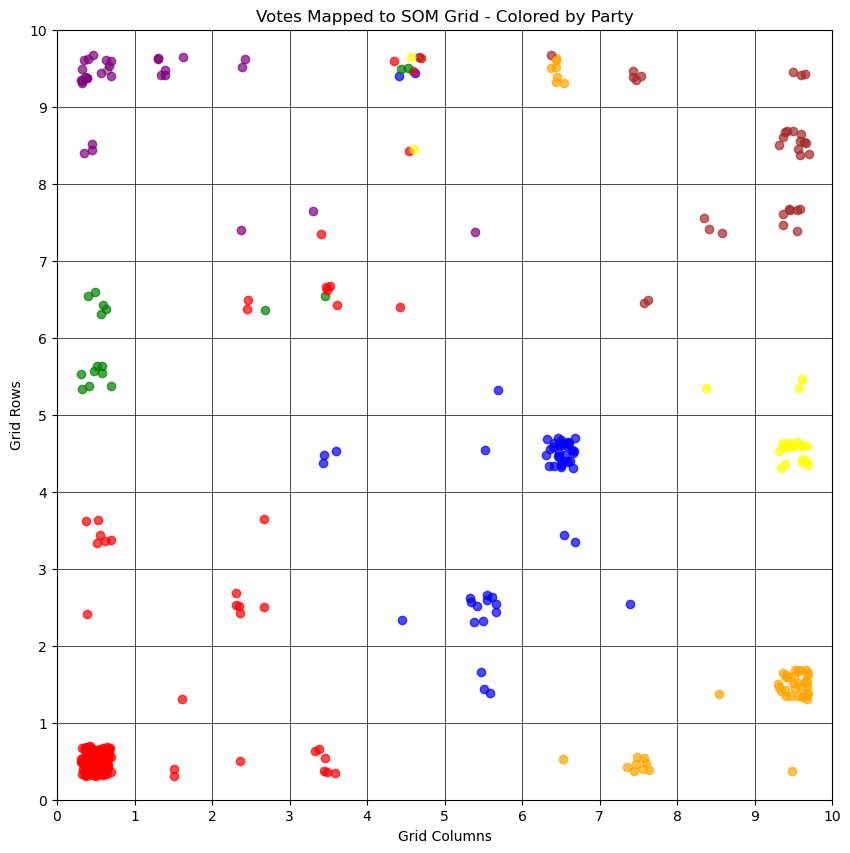

In [17]:
plt.figure(figsize=(10, 10))
for _, row in data_df.iterrows():
    plt.scatter(
        row['plot_x'],
        row['plot_y'],
        color=party_colors[row['party']],
        marker='o',  # You can use a common marker shape here or vary it further
        alpha=0.7    # Adjust transparency to help overlapping markers be visible
    )

plt.xticks(np.arange(0, 11))
plt.yticks(np.arange(0, 11))
plt.grid(which='both', color='black', linestyle='-', linewidth=0.5)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Votes Mapped to SOM Grid - Colored by Party')
plt.xlabel('Grid Columns')
plt.ylabel('Grid Rows')
plt.show()

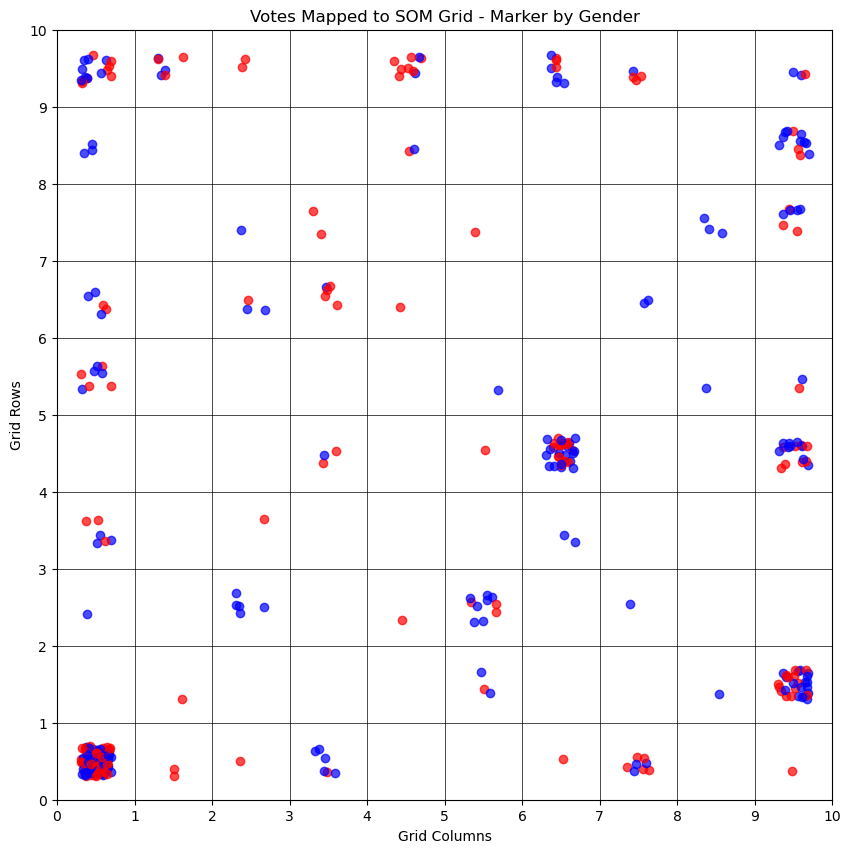

In [18]:
plt.figure(figsize=(10, 10))
for _, row in data_df.iterrows():
    plt.scatter(
        row['plot_x'],
        row['plot_y'],
        color=gender_color[row['gender']],  # You can use a uniform color or even combine with party colors if desired
        marker='o',
        alpha=0.7
    )

plt.xticks(np.arange(0, 11))
plt.yticks(np.arange(0, 11))
plt.grid(which='both', color='black', linestyle='-', linewidth=0.5)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Votes Mapped to SOM Grid - Marker by Gender')
plt.xlabel('Grid Columns')
plt.ylabel('Grid Rows')
plt.show()


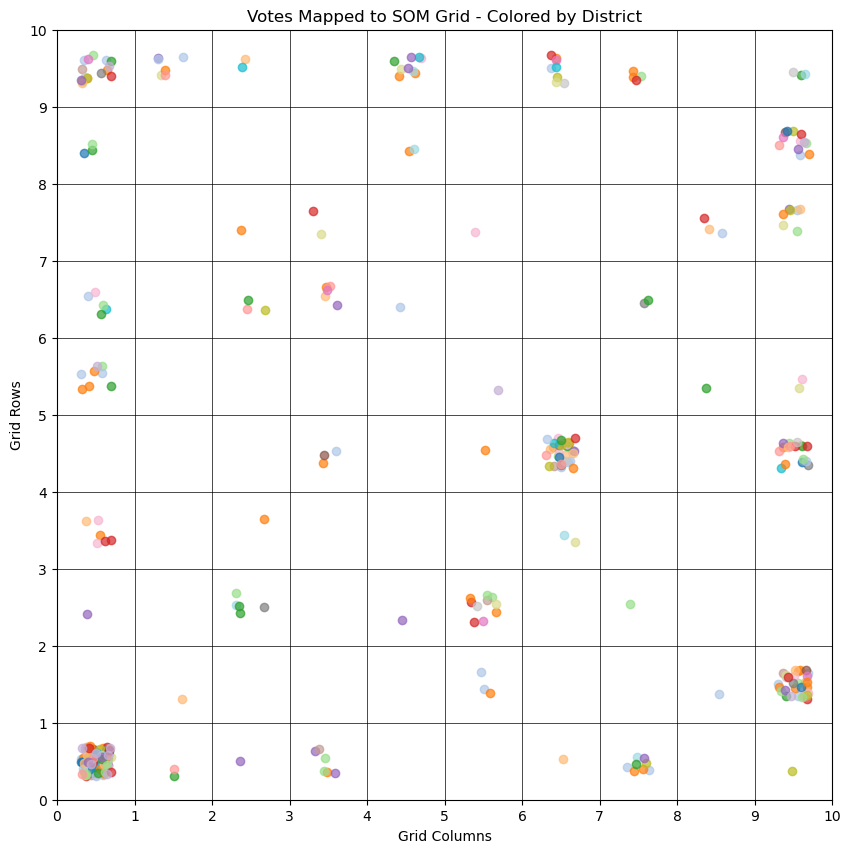

In [19]:
# For demonstration, let's assume you have up to 30 districts.
import matplotlib.cm as cm
district_colors = {d: cm.tab20(d % 20) for d in np.unique(data_df['district'])}

plt.figure(figsize=(10, 10))
for _, row in data_df.iterrows():
    plt.scatter(
        row['plot_x'],
        row['plot_y'],
        color=district_colors[row['district']],
        marker='o',
        alpha=0.7
    )

plt.xticks(np.arange(0, 11))
plt.yticks(np.arange(0, 11))
plt.grid(which='both', color='black', linestyle='-', linewidth=0.5)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Votes Mapped to SOM Grid - Colored by District')
plt.xlabel('Grid Columns')
plt.ylabel('Grid Rows')
plt.show()
